In [1]:
!pwd

/Users/eshaangupta/prod/nlp/Sentiment-Analysis


In [3]:
!cd `mktemp -d`
!python3 -m venv virt
!source virt/bin/activate
!cd ~/nlp/prod/Sentiment-Analysis

/bin/bash: line 0: cd: /Users/eshaangupta/nlp/prod/Sentiment-Analysis: No such file or directory


In [6]:
!pip install pandas scikit-learn matplotlib numpy nltk

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/96/08/9ad65176f854fd5eb806a27da6e8b6c12d5ddae7ef3bd80d8b3009099333/pandas-2.2.2-cp39-cp39-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/d9/ff/5ae7e924925499902104bf046ccd9b2b2e078171bcedc4ee2e2f2d2cacca/scikit_learn-1.4.2-cp39-cp39-macosx_12_0_arm64.whl.metadata
  Obtaining dependency information for nltk from https://files.pythonhosted.org/packages/a6/0a/0d20d2c0f16be91b9fa32a77b76c60f9baf6eba419e5ef5deca17af9c582/nltk-3.8.1-py3-none-any.whl.metadata
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/9c/3d/a121f284241f08268b21359bd425f7d4825cffc5ac5cd0e1b3d82ffd2b10/pytz-2024.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.o

In [16]:
import os
import pandas as pd
import sklearn
import numpy as np 
import nltk
import matplotlib.pyplot as plt
import utils

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/eshaangupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
df = pd.read_csv('Data.csv')
df

,Unnamed: 0,review,sentiment
0,0,One of the other reviewers has mentioned that ...,positive
1,1,A wonderful little production. <br /><br />The...,positive
2,2,I thought this was a wonderful way to spend ti...,positive
3,4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,5,"Probably my all-time favorite movie, a story o...",positive
...,...,...,...
4995,4945,"The Bermuda Triangle ,we are told in this wast...",negative
4996,4946,"After watching this on the MST3K episode, I ha...",negative
4997,4947,Boring movie. Poor plot. Poor actors. The movi...,negative
4998,4948,"This is not a boring movie, the audience might...",negative


In [12]:
df['sentiment'].value_counts()
# to check for imbalance in the data

sentiment
positive    2500
negative    2500
Name: count, dtype: int64

In [10]:
df_positive = df[df['sentiment']=='positive']
df_negative = df[df['sentiment']=='negative']

In [14]:
df_train = pd.concat([df_positive[:2000], df_negative[:2000]])
df_test = pd.concat([df_positive[2000:], df_negative[2000:]])

In [15]:
df_train

,Unnamed: 0,review,sentiment
0,0,One of the other reviewers has mentioned that ...,positive
1,1,A wonderful little production. <br /><br />The...,positive
2,2,I thought this was a wonderful way to spend ti...,positive
3,4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,5,"Probably my all-time favorite movie, a story o...",positive
...,...,...,...
4495,3953,Let's see: what are the advantages to watching...,negative
4496,3954,"For one thing, he produced this movie. It has ...",negative
4497,3956,Contains spoilers The movie plot can be summar...,negative
4498,3959,"After high school Track & Field athelete, Laur...",negative


### Naive Bayes

In [18]:
processed_reviews = []
for i, row in df_train.iterrows():
    review = row['review']
    trimmed_review = utils.trim(review)
    tokenized_review = utils.tokenize(trimmed_review)
    clean_review = utils.removeStopwordsAndPunctuation(tokenized_review)
    stemmed_review = utils.stem(clean_review)
    processed_reviews.append(stemmed_review)

In [19]:
processed_reviews[0]

['one',
 'review',
 'mention',
 'watch',
 '1',
 'oz',
 'episod',
 'hook',
 'right',
 'exactli',
 'happen',
 'br',
 'br',
 'first',
 'thing',
 'struck',
 'oz',
 'brutal',
 'unflinch',
 'scene',
 'violenc',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'heart',
 'timid',
 'show',
 'pull',
 'punch',
 'regard',
 'drug',
 'sex',
 'violenc',
 'hardcor',
 'classic',
 'use',
 'word',
 'br',
 'br',
 'call',
 'oz',
 'nicknam',
 'given',
 'oswald',
 'maximum',
 'secur',
 'state',
 'penitentari',
 'focus',
 'mainli',
 'emerald',
 'citi',
 'experiment',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inward',
 'privaci',
 'high',
 'agenda',
 'em',
 'citi',
 'home',
 'mani',
 '..',
 'aryan',
 'muslim',
 'gangsta',
 'latino',
 'christian',
 'italian',
 'irish',
 '...',
 'scuffl',
 'death',
 'stare',
 'dodgi',
 'deal',
 'shadi',
 'agreement',
 'never',
 'far',
 'away',
 'br',
 'br',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'goe',
 'show',
 'dare

In [24]:
freq = {}
D_pos = D_neg = 0
for i, review in enumerate(processed_reviews):
    sentiment = df_train.iloc[i, 2]
    D_pos += (sentiment == 'positive')
    D_neg += (sentiment == 'negative')
    for word in review:
        key = (word, sentiment)
        freq[key] = freq.get(key, 0) + 1


In [23]:
freq

{('one', 'positive'): 2161,
 ('review', 'positive'): 169,
 ('mention', 'positive'): 113,
 ('watch', 'positive'): 1101,
 ('1', 'positive'): 75,
 ('oz', 'positive'): 24,
 ('episod', 'positive'): 226,
 ('hook', 'positive'): 34,
 ('right', 'positive'): 270,
 ('exactli', 'positive'): 83,
 ('happen', 'positive'): 229,
 ('br', 'positive'): 7849,
 ('first', 'positive'): 720,
 ('thing', 'positive'): 531,
 ('struck', 'positive'): 14,
 ('brutal', 'positive'): 41,
 ('unflinch', 'positive'): 2,
 ('scene', 'positive'): 778,
 ('violenc', 'positive'): 85,
 ('set', 'positive'): 327,
 ('word', 'positive'): 144,
 ('go', 'positive'): 660,
 ('trust', 'positive'): 21,
 ('show', 'positive'): 867,
 ('faint', 'positive'): 2,
 ('heart', 'positive'): 139,
 ('timid', 'positive'): 2,
 ('pull', 'positive'): 80,
 ('punch', 'positive'): 19,
 ('regard', 'positive'): 57,
 ('drug', 'positive'): 70,
 ('sex', 'positive'): 97,
 ('hardcor', 'positive'): 13,
 ('classic', 'positive'): 230,
 ('use', 'positive'): 385,
 ('call',

In [25]:
D = len(processed_reviews)
log_prior = np.log(D_pos) / np.log(D_neg)


In [27]:
log_likelihood = {}
vocab = set([tup[0] for tup in freq.keys()])
V = len(vocab)

In [29]:
N_pos = 0
N_neg = 0
for word in vocab:
    N_pos += freq.get((word, 'positive'), 0)
    N_neg += freq.get((word, 'negative'), 0)

In [30]:
for word in vocab:
    pos = freq.get((word, 'positive'), 0)
    neg = freq.get((word, 'negative'), 0)
    f_pos = (pos + 1) / (N_pos + V)
    f_neg = (neg + 1) / (N_neg + V)
    log_likelihood[word] = np.log(f_pos) - np.log(f_neg)

In [31]:
processed_test_reviews = []
for i, row in df_test.iterrows():
    review = row['review']
    trimmed_review = utils.trim(review)
    tokenized_review = utils.tokenize(trimmed_review)
    clean_review = utils.removeStopwordsAndPunctuation(tokenized_review)
    stemmed_review = utils.stem(clean_review)
    processed_test_reviews.append(stemmed_review)

In [34]:
result = []
for i, review in enumerate(processed_test_reviews):
    score = log_prior
    for word in review:
        if word in log_likelihood:
            score += log_likelihood[word]
    if score >= 0:
        result.append('positive')
    else:
        result.append('negative')

In [71]:
accuracy = 0
expected = []
for i in range(len(result)):
    expected.append(df_test.iloc[i, 2])
    if result[i] == df_test.iloc[i, 2]:
        accuracy += 1
accuracy = accuracy / len(result)
accuracy

0.851

In [72]:
cm = sklearn.metrics.confusion_matrix(result, expected)

<Axes: >

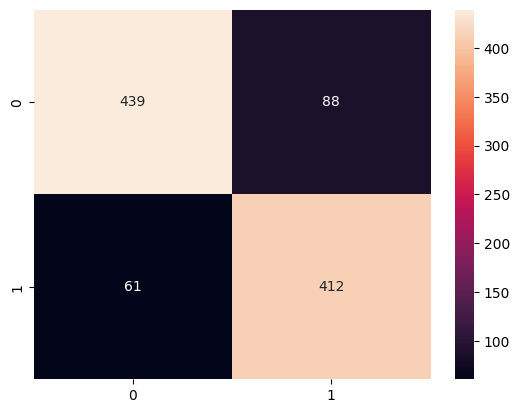

In [73]:
sns.heatmap(cm, annot=True, fmt='g')

In [40]:
df_train.columns

Index(['Unnamed: 0', 'review', 'sentiment'], dtype='object')

In [45]:
X_train = df_train[['review']]
X_test = df_test[['review']]
Y_train = df_train[['sentiment']]
Y_test = df_test[['sentiment']]

In [53]:
X_train = np.reshape(X_train, (4000,))
Y_train = np.reshape(Y_train, (4000,))
X_test = np.reshape(X_test, (1000,))
Y_test = np.reshape(Y_test, (1000,))

### SVM

In [54]:
'''
TF-IDF (Term Frequency, Inverse Document Frequency)
Suppose there is some word, which is frequent in all the
documents, then if the dataset is balanced, then this word
won't be significant to any of the documents and would be 
assigned less weight.
There is some another word, which is frequent in only few
of the documents and not in others, then this word is significant
to these docs and would be assigned higher weights.
This is what this method does, for some word, it calculates the 
overall frequency and multiplies it by the inverse frequency of 
the word overall documents.
'''
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(stop_words = 'english')
train_x_vector = tfidf.fit_transform(X_train)
train_x_vector

<4000x34941 sparse matrix of type '<class 'numpy.float64'>'
	with 354304 stored elements in Compressed Sparse Row format>

In [55]:
test_x_vector = tfidf.transform(X_test)

In [56]:
Y_train.shape

(4000,)

In [57]:
svc = sklearn.svm.SVC(kernel = 'linear')
svc.fit(train_x_vector, Y_train)

SVC(kernel='linear')

In [58]:
print(svc.predict(tfidf.transform(['A good movie'])))
print(svc.predict(tfidf.transform(['An excellent movie'])))
print(svc.predict(tfidf.transform(['I did not like this movie at all'])))

['positive']
['positive']
['negative']


In [59]:
svc.score(test_x_vector, Y_test)

0.864

In [62]:
conf_mat = sklearn.metrics.confusion_matrix(Y_test, 
                            svc.predict(test_x_vector), 
                            labels=['positive', 'negative'])

In [65]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [66]:
import seaborn as sns

<Axes: >

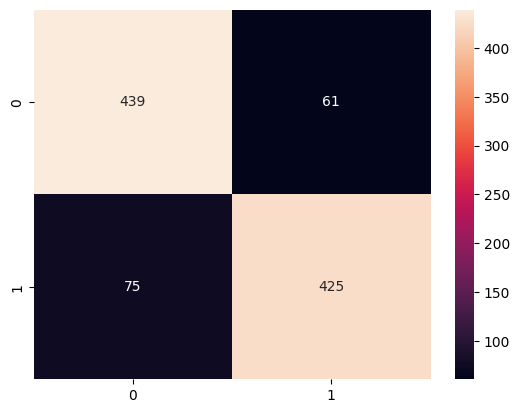

In [69]:
sns.heatmap(conf_mat, annot=True, fmt='g')

In [70]:
sklearn.metrics.f1_score(Y_test, svc.predict(test_x_vector),
         labels=['positive', 'negative'],
         average=None)

array([0.86587771, 0.86206897])